# Jet Physics Dataset: A Walk-through

The Large Hadron Collider (LHC) is pushing for higher energy of collisions. The current objective is to collect 10 times more data than in the initial design by around 2030. This urges the experiments to implement more complex algorithms early in physics event selection process. We exploit fast inference neural networks suitable for the implementation in the Compact Muon Solenoid (CMS) trigger system. Our case study is a jet detection using calorimeter energy deposit.

This file provides background on jets, calorimeters and trigger system. It gives a general overview of the production of the dataset and visualizes the training data.

In [1]:
# Before starting import everything necessary

import getpass
import simplejson as json
import numpy as np
import os
import uproot

In [2]:
# Set presentation settings

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.ticker as tick

from matplotlib import cm
from matplotlib.colors import SymLogNorm
from mpl_toolkits import mplot3d

%matplotlib inline

matplotlib.rcParams["figure.figsize"] = (16.0, 6.0)

matplotlib.rcParams['font.family'] = 'sans-serif'

matplotlib.rcParams["axes.spines.left"] = True
matplotlib.rcParams["axes.spines.top"] = True
matplotlib.rcParams["axes.spines.right"] = True
matplotlib.rcParams["axes.spines.bottom"] = True
matplotlib.rcParams["axes.labelsize"] = 16
matplotlib.rcParams["axes.titlesize"] = 14

matplotlib.rcParams["xtick.top"] = True
matplotlib.rcParams["ytick.right"] = True
matplotlib.rcParams["xtick.direction"] = "in"
matplotlib.rcParams["ytick.direction"] = "in"
matplotlib.rcParams["xtick.labelsize"] = 10
matplotlib.rcParams["ytick.labelsize"] = 10
matplotlib.rcParams["xtick.major.size"] = 10
matplotlib.rcParams["ytick.major.size"] = 10
matplotlib.rcParams["xtick.minor.size"] = 5
matplotlib.rcParams["ytick.minor.size"] = 5
matplotlib.rcParams["xtick.minor.visible"] = True

matplotlib.rcParams["lines.linewidth"] = 2

matplotlib.rcParams["legend.fontsize"] = 14

with open('data/palette.json') as json_file:
    color_palette = json.load(json_file)

In [3]:
# Get access to files in EOS

os.system("echo %s | kinit" % getpass.getpass())

········


0

In [4]:
# Set the source paths

JSON_OUT_DIR = './data/file-configuration.json'

SOURCE_PATH = '/eos/project/d/dshep/CEVA/'

EXAMPLE_FILE = 'RSGraviton_WW_NARROW/RSGraviton_WW_NARROW_0.root'

## Jets

A jet is a collimated spray of particles. Used to probe the underlying elementary particle that initiates the cascade of particles.

In [5]:
# Define mass of quarks, in GeV
q_mass = {'b': 4.18, 'q': 0.096, 't': 173.1, 'W': 80.39, 'h': 124.97}

# Define radius of a jet
delta_r = {'b': 0.4, 'q': 0.4, 't': 0.8, 'W': 0.8, 'h': 0.8}

# Assigned jet classes
classes = {'b': 1, 'q': 5, 't': 4, 'W': 3, 'h': 2}

def get_class(jtype):
    return classes[jtype]

In [6]:
# Print available jet datasets

with open(JSON_OUT_DIR, 'r') as f:
    config = json.loads(f.read())    

for jet in ['bb', 'tt', 'hh', 'WW']:
    print('%s: %s events, %s jets, %s jets per event' %
          (jet,
           config[jet]['events'],
           config[jet]['jets'],
           round(config[jet]['jets']/config[jet]['events'], 2)))

bb: 769973 events, 3738320 jets, 4.86 jets per event
tt: 940000 events, 1945845 jets, 2.07 jets per event
hh: 990000 events, 2111569 jets, 2.13 jets per event
WW: 911000 events, 2056696 jets, 2.26 jets per event


## Calorimeters

Calorimeters are devices that measure the energy of the long-lived particles. CMS has two types of calorimeters: electromagentic (ECAL) and hadron (HCAL). ECAL is responsible for measuring the energy of electrons and photons. Neutral particles (e.g. photons) are not visible in tracking devices but revealed by the energy deposit they leave in the calorimeters. . ECAL is made of 76000 scintillating PbWO$_4$ crystals. HCAL measures the energy of long-lived charged and neutral hadrons. Hadrons begin to lose energy in ECAL only to be stopped in HCAL.

Our data is generated using Delphes. The calorimeters have a finite segmentation in pseudo-rapidity $\eta$ and azimuthal angle $\phi$. The coordinate of the resulting calorimeter energy deposit, the tower, is computed as the geometrical centre of the cell.

In [7]:
# Crystal dimentions

crystal_dim = 0.0174

Number of Towers: 2832


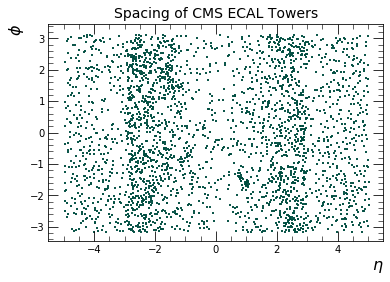

In [8]:
# Placement of towers in an example event

file = uproot.open("%s/%s" % (SOURCE_PATH, EXAMPLE_FILE))

print("Number of Towers: %s" % (file['Delphes']['Tower']['Tower.Phi'].array()[0].shape[0]))

plt.xlabel('$\eta$', horizontalalignment='right', x=1.0)
plt.ylabel('$\phi$', horizontalalignment='right', y=1.0)
plt.scatter(file['Delphes']['Tower']['Tower.Eta'].array()[0],
            file['Delphes']['Tower']['Tower.Phi'].array()[0],
            color=color_palette['teal']['shade_900'],
            marker='s', s=1);
plt.title('Spacing of CMS ECAL Towers')
plt.show();

In order to transform calorimeter energy deposits we need to define grid edges of the continues variables $\phi$ and $\eta$ to map them to pixel coorinates.

In [9]:
# Grid edges

MIN_ETA = -3
MAX_ETA = 3

def get_edges_ecal(edge_index, tower, sample_events=1000):
    file = uproot.open("%s/%s" % (SOURCE_PATH, EXAMPLE_FILE))
    
    tower_flag_full_file = file['Delphes']['Tower'][tower].array()       
    edges_full_file = file['Delphes']['Tower']['Tower.Edges[4]'].array()

    global_edges = np.array([], dtype=np.float32)
    
    for i in range(sample_events):
        
        edges_event = edges_full_file[i][tower_flag_full_file[i] > 0]
        
        global_edges = np.append(global_edges, edges_event[:,edge_index])
        global_edges = np.append(global_edges, edges_event[:,edge_index+1])
        
        global_edges = np.unique(global_edges)
        
    return global_edges

edges_eta_ecal = get_edges_ecal(edge_index=0, tower='Tower.Eem')
edges_phi_ecal = get_edges_ecal(edge_index=2, tower='Tower.Eem')

edges_eta_hcal = get_edges_ecal(edge_index=0, tower='Tower.Ehad')
edges_phi_hcal = get_edges_ecal(edge_index=2, tower='Tower.Ehad')

edges_eta_ecal = edges_eta_ecal[(edges_eta_ecal > MIN_ETA) & (edges_eta_ecal < MAX_ETA)]
edges_eta_hcal = edges_eta_hcal[(edges_eta_hcal > MIN_ETA) & (edges_eta_hcal < MAX_ETA)]

print(edges_eta_ecal.shape)
print(edges_eta_hcal.shape)
print(edges_phi_ecal.shape)
print(edges_phi_hcal.shape)

(341,)
(205,)
(361,)
(361,)


## Trigger

Each event corresponds to around 1 MB in unprocessed form. The LHC operates at the rate of 40 MHz. Thus, the LHC is one of the largest sources of data in the world today. Trigger system selects interesting events due to storage constrains. Trigger system is essentially a hierarchical set of algorithms. The Level 1 (L1) Trigger, reduces the 40 MHz input to a 100 kHz rate. Implemented on FPGAs and ASICs with approximately 3.2 $\mu$s to decide. High Level Trigger (HLT) scales the 100 kHz stream from L1 Trigger rate down to 1 kHz. It is a collision reconstruction software running on a computer farm of about one thousand commercial processors. The decision has to happen in approximately 100 ms.

Single-jet triggers are primarly designed to study quantum chromodynamics (QCD), but also be used for many analysis, such as searches for new physics. The L1 jet trigger use transverse momentum $P_T$ computed using both HCAL an ECAL in the central region $|\eta| < 3.0$. The regions $|\eta| > 3.0$ belong to forward calorimeter.

To calculate the minimal $P_T$ for a given $\Delta R$ for triggering the event, we can use the equation below:
$$P_T=\frac{2m}{\Delta R}$$

In [10]:
# Define minimum pt

# Minimum detecable Pt
def get_minimum_pt(jtype):
    return 2*q_mass[jtype] / delta_r[jtype]

In [11]:
# Get the width of jets based on delta R

def get_radius_in_pixels(jtype):
    return np.ceil(delta_r[jtype] / crystal_dim).astype(int)

In [12]:
# Offset in phi - needed to spress cropped bounding boxes in phi

offset_phi = get_radius_in_pixels('t')

## Generating Input Dataset

Our dataset is generated with Delphes. The goal of Delphesis to allow the simulation of a multipurpose detector for phenomenological studies. The simulation includes a tracking system, embedded into a magnetic field, calorimeters and a muon system. Source: https://arxiv.org/abs/1307.6346

In [13]:
# Plotting calorimeter energy deposit image

def plot_calo_image(labels, data2d, data3d, cal='ECAL'):
    
    offset = 15
    
    fig = plt.figure(figsize=(14.0, 6.0))   
    cmap = matplotlib.cm.viridis

    # 3D Plot Energy Deposit
    
    ax = fig.add_subplot(1, 2, 1, projection='3d')
    eta, phi, energy = data3d
    colours = matplotlib.cm.viridis(energy/np.log10(max(energy)))
    width = depth = 3
    ax.bar3d(eta,
             phi,
             np.zeros_like(energy),
             width,
             depth,
             energy,
             color=colours,
             shade=True)
    ax.set_xlabel('$\phi [\degree$]')
    ax.set_ylabel('$\eta$')
    ax.set_zlabel('$E_T$ [GeV]')
    ax.view_init(10, 40);
    
    ax = fig.add_subplot(1, 2, 2)
    
    ax.text(0,
         1.05,
         "CMS",
         weight='bold',
         verticalalignment="top",
         horizontalalignment="left",
         transform=ax.transAxes,
         color="black",
         fontsize=16)

    ax.set_title('%s $E_T$ with tagged jets' % cal, loc="right")
    
    ax.set_xlim([-offset, data2d.shape[1]+offset])
    ax.set_xlabel('$\eta$', horizontalalignment='right', x=1.0)

    def phi_formatter(x, y):
        x = x - 46
        if x < 0:
            x = x + 360
        if x > 360:
            x = x - 360
        return int(x)

    ax.yaxis.set_major_formatter(tick.FuncFormatter(phi_formatter))
    ax.set_ylim([-offset, data2d.shape[0]+offset])
    ax.set_ylabel('$\phi [\degree$]', horizontalalignment='right', y=1.0)

    im = ax.imshow(data2d,
                    norm=SymLogNorm(linthresh=0.03,
                                    vmin=0,
                                    vmax=data2d.max()),
                    interpolation="nearest",
                    cmap=cmap)
    
    for label in labels:

        jet = patches.Rectangle((label[1], label[2]),
                                label[3]-label[1],
                                label[4]-label[2],
                                linewidth=2,
                                edgecolor=color_palette['red']['shade_600'],
                                facecolor='none')
        ax.add_patch(jet)
        ax.text(label[1],
                 label[4],
                 '{}: {:.0f} GeV/c'.format(label[0], label[5]),
                 weight='bold',
                 color='#FAFAFA',
                 bbox={'facecolor': color_palette['red']['shade_900'], 'alpha': 1.0})

    cbar = fig.colorbar(im, extend='max')
    cbar.set_label('$E_T$ [GeV]', rotation=90, horizontalalignment='right', y=1.0)

    plt.show();

In [14]:
# Generate data used for plotting

def get_energy_map(etas, phis, energy, cal='ECAL'):

    if cal == 'ECAL':
        edges_phi = edges_phi_ecal
        edges_eta = edges_eta_ecal
    if cal == 'HCAL':
        edges_phi = edges_phi_hcal
        edges_eta = edges_eta_hcal

    indices_phi = np.squeeze([np.where(edges_phi == i) for i in phis])
    indices_eta = np.squeeze([np.where(edges_eta == i) for i in etas])

    pixels = np.zeros((len(edges_phi)-1, len(edges_eta)-1))
    pixels[indices_phi, indices_eta] = energy

    if cal == 'HCAL':
        pixels = np.hstack(
            (pixels[:,:85], pixels[:,85:-85].repeat(
                5, axis=1), pixels[:,-85:]))

    # Extend image top and bottom by a radius of the biggest jet
    # Prevents cropped boxes in y plane
    pixels = np.vstack((pixels[-offset_phi:, :],
                               pixels,
                               pixels[:offset_phi, :]))

    return pixels, (indices_phi, indices_eta, energy)

In [15]:
def get_bboxes(bbox_pts, bbox_etas, bbox_phis, jtype):

    labels = []
    
    radius = get_radius_in_pixels(jtype)
    minpt = get_minimum_pt(jtype)

    for pt, eta, phi in zip(bbox_pts, bbox_etas, bbox_phis):

        if pt > minpt:
            
            index_eta = np.argmax(edges_eta_ecal >= eta) - 1
            index_phi = np.argmax(edges_phi_ecal >= phi) - 1 + offset_phi

            xmin = int(index_eta-radius)
            xmax = int(index_eta+radius)
            ymin = int(index_phi-radius)
            ymax = int(index_phi+radius)

            if xmin < 0:
                xmin = 0
            if xmax > len(edges_eta_ecal):
                xmax = len(edges_eta_ecal)

            labels.append([jtype, xmin, ymin, xmax, ymax, pt])

    return labels

In [16]:
# Plot examples of input data

def data_generator(file_path, jtype, no_events=1):

    # First load values from file
    file = uproot.open(file_path)

    ecal_energy_full_file = file['Delphes']['Tower']['Tower.Eem'].array()  # ECAL E
    hcal_energy_full_file = file['Delphes']['Tower']['Tower.Ehad'].array()  # HCAL E
    edges_full_file = file['Delphes']['Tower']['Tower.Edges[4]'].array() # Crystal edge
    
    bbox_pt_full_file = file['Delphes']['GenJet']['GenJet.PT'].array() # Jet PT
    bbox_eta_full_file = file['Delphes']['GenJet']['GenJet.Eta'].array() # Jet x
    bbox_phi_full_file = file['Delphes']['GenJet']['GenJet.Phi'].array() # Jet y
    
    for event_number in np.arange(no_events, dtype=int):

        # Get jet labels
        bbox_etas = bbox_eta_full_file[event_number]
        bbox_phis = bbox_phi_full_file[event_number]
        
        etas_mask = (bbox_etas > edges_eta_ecal[0]) & (bbox_etas < edges_eta_ecal[-1])
        
        bbox_etas = bbox_etas[etas_mask]
        bbox_phis = bbox_phis[etas_mask]
        bbox_pts = bbox_pt_full_file[event_number][etas_mask]

        labels = get_bboxes(bbox_pts, bbox_etas, bbox_phis, jtype)

        # Get ECAL info
        ecal_mask = ecal_energy_full_file[event_number] > 0
        
        etas = edges_full_file[event_number][ecal_mask][:, 0]
        phis = edges_full_file[event_number][ecal_mask][:, 2]
        
        etas_mask = (etas > edges_eta_ecal[0]) & (etas < edges_eta_ecal[-1])
        
        etas = etas[etas_mask]
        phis = phis[etas_mask]
        energy = ecal_energy_full_file[event_number][ecal_mask][etas_mask]        

        pixels_2d, pixels_3d = get_energy_map(etas, phis, energy, cal='ECAL')
        
        plot_calo_image(labels, pixels_2d, pixels_3d, cal='ECAL')

        # Get HCAL info
        hcal_mask = hcal_energy_full_file[event_number] > 0
        
        etas = edges_full_file[event_number][hcal_mask][:, 0]
        phis = edges_full_file[event_number][hcal_mask][:, 2]
        
        etas_mask = (etas > edges_eta_hcal[0]) & (etas < edges_eta_hcal[-1])
        
        etas = etas[etas_mask]
        phis = phis[etas_mask]
        energy = hcal_energy_full_file[event_number][hcal_mask][etas_mask]        

        pixels_2d, pixels_3d = get_energy_map(etas, phis, energy, cal='HCAL')

        plot_calo_image(labels, pixels_2d, pixels_3d, cal='HCAL')

h jets


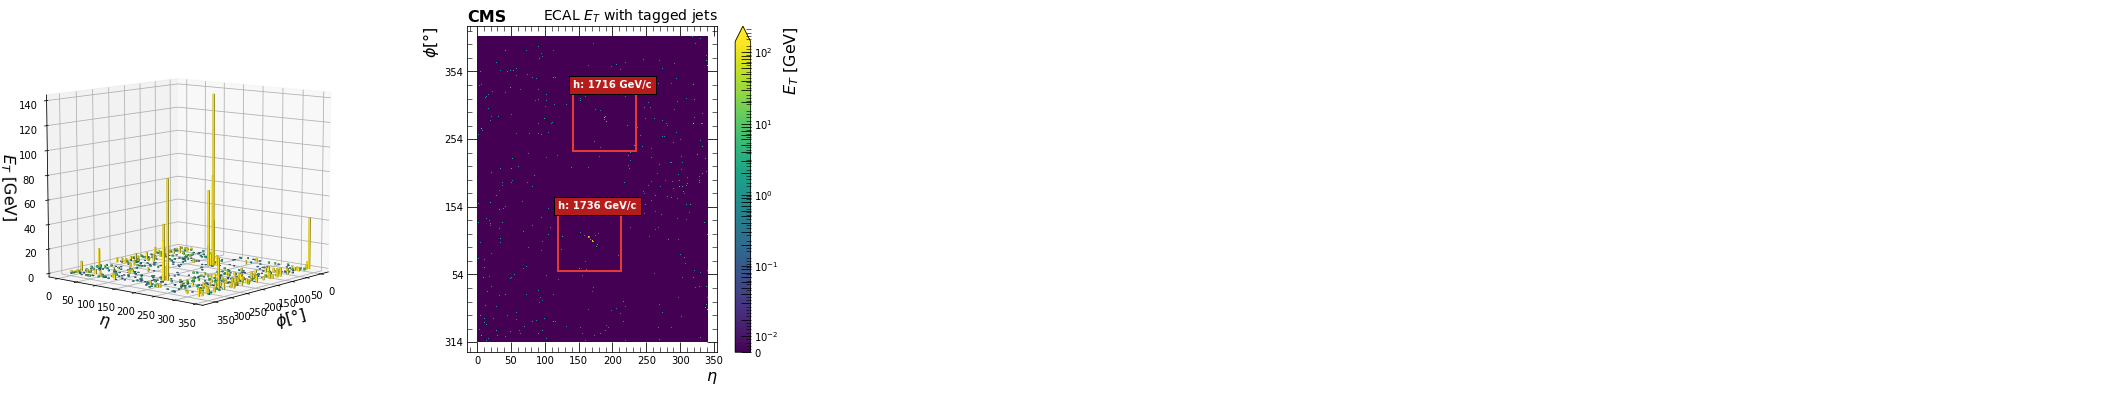

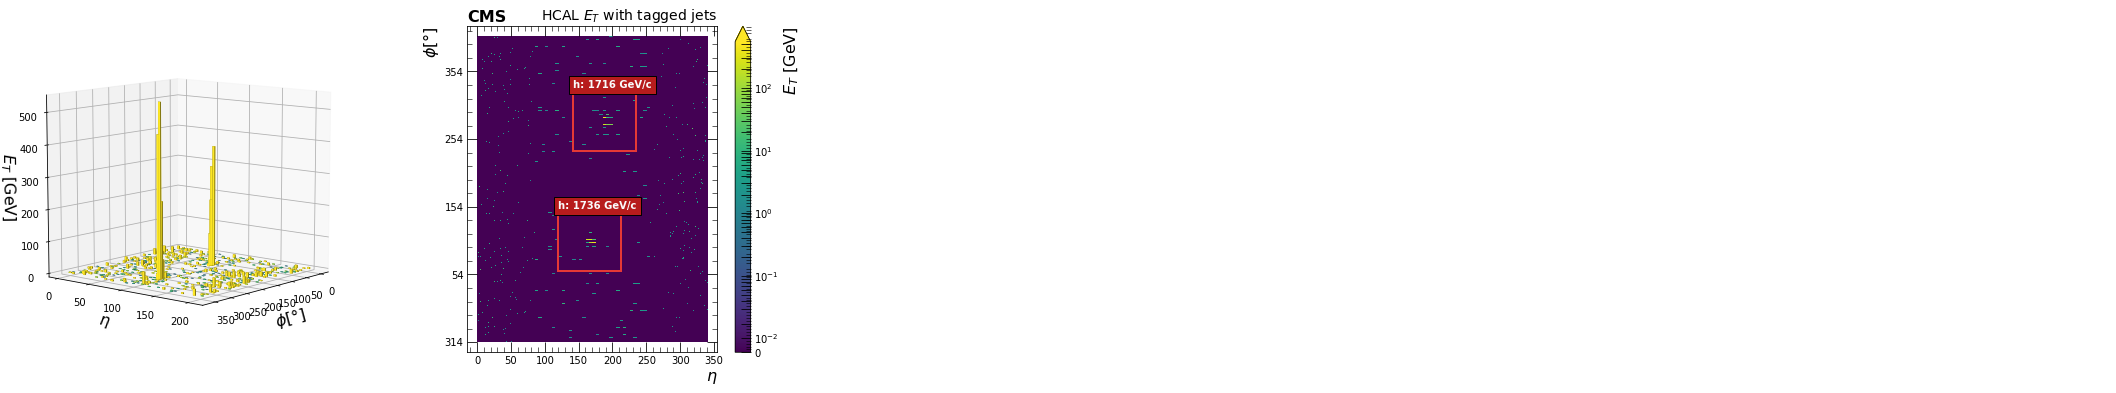

In [17]:
for jtype in ['hh']:
    print('%s jets' % jtype[0])
    data_generator("/eos/project/d/dshep/CEVA/RSGraviton_%s_NARROW/RSGraviton_%s_NARROW_0.root" %
                   (jtype, jtype), jtype[0])